**Modernised credit assessment & document processing** 

In [2]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import IntegerType,StringType,DoubleType

spark = SparkSession \
    .builder \
    .appName("credit score modelling") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

df = spark.read.csv(
    "/Users/hoangphuonganhnguyen/Downloads/synthetic_home_buyer_dataset.csv",
    header=True,
    inferSchema=True
)
print("df schema is: ")
df.printSchema()
df.show(5)

numerical_col = [field.name for field in df.schema.fields if isinstance(field.dataType, (IntegerType, DoubleType))]
categorical_col = [field.name for field in df.schema.fields if isinstance(field.dataType, (StringType))]
print("Numerical columns: ")
print(numerical_col)
print("Categorical columns: ")
print(categorical_col)


25/04/01 21:55:18 WARN Utils: Your hostname, Roses-MacBook-Air-2.local resolves to a loopback address: 127.0.0.1; using 172.24.22.251 instead (on interface en0)
25/04/01 21:55:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/01 21:55:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


df schema is: 
root
 |-- age: integer (nullable = true)
 |-- income: double (nullable = true)
 |-- employment_status: string (nullable = true)
 |-- credit_score: double (nullable = true)
 |-- deposit_amount: double (nullable = true)
 |-- property_value: integer (nullable = true)
 |-- loan_amount: integer (nullable = true)
 |-- loan_to_value_ratio: double (nullable = true)
 |-- first_home_buyer: boolean (nullable = true)
 |-- loan_approved: integer (nullable = true)

+---+--------+-----------------+------------+--------------+--------------+-----------+-------------------+----------------+-------------+
|age|  income|employment_status|credit_score|deposit_amount|property_value|loan_amount|loan_to_value_ratio|first_home_buyer|loan_approved|
+---+--------+-----------------+------------+--------------+--------------+-----------+-------------------+----------------+-------------+
| 34|112987.0|        Full-time|       708.0|       57534.0|        638894|     581360|               0.91|     

In [11]:
import pandas as pd
import statsmodels.api as sm

df = pd.read_csv("/Users/hoangphuonganhnguyen/Downloads/synthetic_home_buyer_dataset.csv")

df_clean = df.dropna(subset=['income', 'credit_score', 'deposit_amount', 'loan_to_value_ratio', 'loan_approved'])

# feature matrix (X) and target (y)
X = df_clean[['income', 'credit_score', 'deposit_amount', 'loan_to_value_ratio']]
X = sm.add_constant(X)  # Add intercept
y = df_clean['loan_approved']

glm_model = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(glm_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:          loan_approved   No. Observations:                  856
Model:                            GLM   Df Residuals:                      851
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -263.42
Date:                Thu, 03 Apr 2025   Deviance:                       526.84
Time:                        17:20:35   Pearson chi2:                 2.48e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4504
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  47.8600    

Best Threshold: 0.28
Best F1-Score: 0.79


/var/folders/86/88b76n414cj0jc4h_tg24vnm0000gp/T/ipykernel_20121/4081662279.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['PD'] = glm_model.predict(X)
/var/folders/86/88b76n414cj0jc4h_tg24vnm0000gp/T/ipykernel_20121/4081662279.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['loan_prediction'] = (df_clean['PD'] >= best_threshold).astype(int)


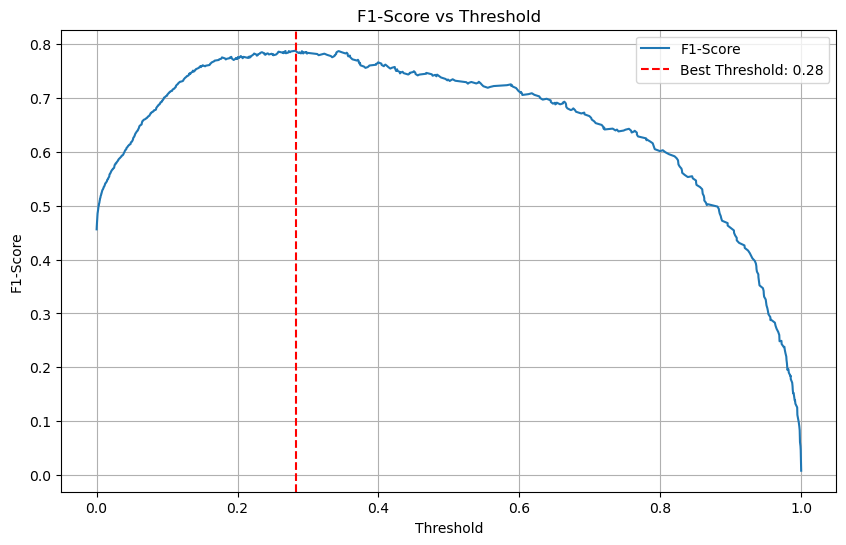

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score
import matplotlib.pyplot as plt
import numpy as np

#predict probability of defaults
df_clean['PD'] = glm_model.predict(X)

#precision recall and F1 analysis
precision, recall, thresholds = precision_recall_curve(y, df_clean['PD'])
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# find threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1-Score: {best_f1:.2f}")

# apply threshold to get final binary label
df_clean['loan_prediction'] = (df_clean['PD'] >= best_threshold).astype(int)

# visualize F1 vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores[:-1], label="F1-Score")
plt.axvline(best_threshold, color='red', linestyle='--', label=f"Best Threshold: {best_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("F1-Score")
plt.title("F1-Score vs Threshold")
plt.legend()
plt.grid(True)
plt.show()


We come to a conclusion:
PD ≥ 0.28 = Predict loan approved (1)
PD < 0.28 = Predict loan rejected (0)

In [5]:
import pandas as pd
import statsmodels.api as sm
# 1. Apply the best threshold to create prediction label
df_clean['loan_prediction'] = (df_clean['PD'] >= best_threshold).astype(int)

# 2. Add Credit Risk Components
df_clean['EAD'] = df_clean['loan_amount'] * 0.9  # Example exposure rate
df_clean['LGD'] = df_clean['loan_to_value_ratio'].apply(lambda x: 0.2 if x < 0.8 else 0.6)
df_clean['ECL'] = df_clean['PD'] * df_clean['EAD'] * df_clean['LGD']

# 3. Save final dataset
df_clean.to_csv("final_credit_risk_scoring.csv", index=False)
print("Final dataset exported to: final_credit_risk_scoring.csv")

df_final = pd.read_csv("final_credit_risk_scoring.csv")
df_final.head(10)



Final dataset exported to: final_credit_risk_scoring.csv


/var/folders/86/88b76n414cj0jc4h_tg24vnm0000gp/T/ipykernel_20121/420865995.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['loan_prediction'] = (df_clean['PD'] >= best_threshold).astype(int)
/var/folders/86/88b76n414cj0jc4h_tg24vnm0000gp/T/ipykernel_20121/420865995.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['EAD'] = df_clean['loan_amount'] * 0.9  # Example exposure rate
/var/folders/86/88b76n414cj0jc4h_tg24vnm0000gp/T/ipykernel_20121/420865995.py:8: SettingWithCopyWarning: 
A 

,age,income,employment_status,credit_score,deposit_amount,property_value,loan_amount,loan_to_value_ratio,first_home_buyer,loan_approved,PD,loan_prediction,EAD,LGD,ECL
0,34,112987.0,Full-time,708.0,57534.0,638894,581360,0.91,True,0,0.144721,0,523224.0,0.6,45432.790844
1,31,103492.0,Full-time,590.0,63181.0,444050,380869,0.86,True,0,0.220489,0,342782.1,0.6,45347.792405
2,35,86192.0,Full-time,662.0,45099.0,435971,390872,0.90,True,0,0.052487,0,351784.8,0.6,11078.459776
3,41,72061.0,Full-time,695.0,44761.0,659134,614373,0.93,True,0,0.012569,0,552935.7,0.6,4169.851384
4,30,98964.0,Contract,689.0,39171.0,640561,601390,0.94,True,0,0.004321,0,541251.0,0.6,1403.322638
5,41,102903.0,Full-time,697.0,41740.0,488364,446624,0.91,True,0,0.065773,0,401961.6,0.6,15862.962693
6,36,97703.0,Self-employed,629.0,62391.0,543367,480976,0.89,True,0,0.073883,0,432878.4,0.6,19189.532945
7,29,105991.0,Full-time,675.0,46608.0,578980,532372,0.92,True,0,0.018128,0,479134.8,0.6,5211.467207
8,35,74295.0,Full-time,591.0,67704.0,472328,404624,0.86,True,0,0.231662,0,364161.6,0.6,50617.394579
9,29,111347.0,Full-time,675.0,60520.0,540877,480357,0.89,True,1,0.250572,0,432321.3,0.6,64996.578406


### Model Output & Its Role in the Credit Risk Framework

The finalized dataset contains several key metrics that directly address internal blockers outlined in the framework. These include the **probability of default (PD)**, a binary **loan prediction** label, and IFRS 9-aligned credit risk components: **EAD**, **LGD**, and **ECL**.

---

#### Numbers explanation

- **PD (Probability of Default):**  
  Indicates the model’s estimated likelihood of a borrower defaulting.  
  Example: A PD of `0.22` = 22% chance of default.  
  → Enables fine-grained, data-driven credit scoring instead of static rules.

- **Loan Prediction:**  
  Binary classification based on optimal threshold (e.g. `0.28`) from F1 tuning.  
  → Flags whether a loan should be approved (`1`) or not (`0`).  
  → Supports automation and faster routing of clean applications.

- **EAD (Exposure at Default):**  
  Estimated loss exposure (set as `90%` of loan amount).  
  → Reflects potential loan book impact if customer defaults.

- **LGD (Loss Given Default):**  
  Rule-based: higher for high LVR loans (e.g. 60%).  
  → Helps simulate different scenarios in asset-backed lending.

- **ECL (Expected Credit Loss):**  
  Computed as: `ECL = PD × EAD × LGD`  
  → Core risk metric that quantifies expected monetary loss  
  → Used for capital provisioning, scenario testing, and IFRS 9 compliance

---

#### How this support the framework

These outputs directly tackle several internal blockers:

| Internal Blocker                    | Enabled Solution                                  |
|-------------------------------------|---------------------------------------------------|
| No advanced credit risk modeling    | PD, EAD, LGD, ECL modeling for scoring + risk   |
| Weak model validation loop          | Model tested, tuned (F1-optimal threshold)      |
| No data audit/process               | Pre-cleaned and profiled dataset               |
| System overload risk                | Model supports automation of clean approvals    |

---

This positions the model as a **Point in Time (PiT) modular, explainable, and automation-ready engine** — helping Interstellar Bank scale responsibly under pressure.


### OCR simulation 
Simulate reading a bank statement or payslip image/text and convert it into structured inputs your model understands (e.g. income, credit_score, deposit_amount, loan_to_value_ratio, etc.)

In [ ]:
import re

ocr_text = """
Client Name: Davis Tran
Employment Status: Full-time
Annual Income: $85,000
Credit Score: 712
Deposit Amount: $42,000
Property Value: $510,000
Loan Amount: $420,000
"""

def extract_from_ocr(text):
    income = float(re.search(r"Income:\s*\$?([\d,]+)", text).group(1).replace(",", ""))
    credit_score = int(re.search(r"Credit Score:\s*(\d+)", text).group(1))
    deposit = float(re.search(r"Deposit Amount:\s*\$?([\d,]+)", text).group(1).replace(",", ""))
    property_value = float(re.search(r"Property Value:\s*\$?([\d,]+)", text).group(1).replace(",", ""))
    loan_amount = float(re.search(r"Loan Amount:\s*\$?([\d,]+)", text).group(1).replace(",", ""))
    lvr = round(loan_amount / property_value, 2)

    return {
        "income": income,
        "credit_score": credit_score,
        "deposit_amount": deposit,
        "loan_amount": loan_amount,
        "loan_to_value_ratio": lvr
    }

sample_input = extract_from_ocr(ocr_text)
print(sample_input)


{'income': 85000.0, 'credit_score': 712, 'deposit_amount': 42000.0, 'loan_amount': 420000.0, 'loan_to_value_ratio': 0.82}


In [ ]:
import pandas as pd
import statsmodels.api as sm

# convert to df
input_df = pd.DataFrame([sample_input])
X_new = sm.add_constant(input_df)

# start predicting PD and threshold
pd_score = glm_model.predict(X_new)[0]
loan_decision = 1 if pd_score >= best_threshold else 0

print(f"Predicted PD: {pd_score:.4f}")
print(f"Loan {'APPROVED' if loan_decision else 'REJECTED'} (Threshold: {best_threshold})")


Predicted PD: 1.0000
Loan APPROVED (Threshold: 0.2824467350485985)


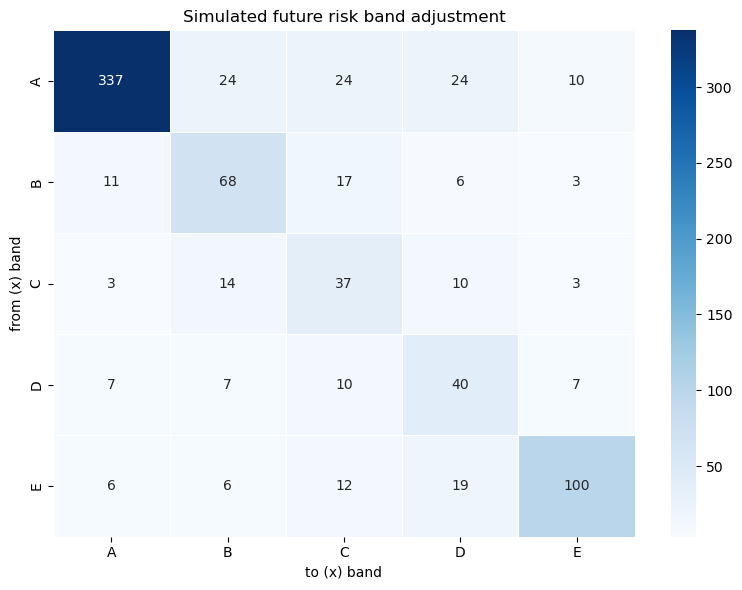

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("final_credit_risk_scoring.csv")  # Adjust path if needed

#assigning PD band
def assign_pd_band(pd_value):
    if pd_value <= 0.2:
        return 'A'
    elif pd_value <= 0.4:
        return 'B'
    elif pd_value <= 0.6:
        return 'C'
    elif pd_value <= 0.8:
        return 'D'
    else:
        return 'E'

df['pd_band'] = df['PD'].apply(assign_pd_band)

# count current distribution
current_distribution = df['pd_band'].value_counts().reindex(['A', 'B', 'C', 'D', 'E'], fill_value=0).values

# transition matrix
transition_matrix = pd.DataFrame({
    'A': [0.70, 0.10, 0.05, 0.10, 0.05],
    'B': [0.05, 0.60, 0.20, 0.10, 0.05],
    'C': [0.05, 0.15, 0.55, 0.15, 0.10],
    'D': [0.05, 0.05, 0.15, 0.60, 0.15],
    'E': [0.02, 0.03, 0.05, 0.10, 0.80]
}, index=['A', 'B', 'C', 'D', 'E'])

# multiply to simulate future risk band distribution
future_distribution = pd.DataFrame(
    data=(current_distribution[:, None] * transition_matrix.values),
    columns=transition_matrix.columns,
    index=transition_matrix.index
)

plt.figure(figsize=(8, 6))
sns.heatmap(future_distribution, annot=True, fmt=".0f", cmap="Blues", linewidths=0.5)
plt.title("Simulated future risk band adjustment")
plt.xlabel("to (x) band")
plt.ylabel("from (x) band")
plt.tight_layout()
plt.show()


For example, if 100 customers are in Band B now, and the transition matrix shows:
- 50% stay in B
- 20% drop to A
- 30% move to C
It helps Interstellar Bank:
- Forecast how many customers will become riskier over time
- Plan how much capital to set aside (provisions)
- Build staged ECL models as required by IFRS 9 (Stage 1, 2, 3 loans)
- Monitor risk migration and take proactive action before customers default
Over time, customer risk can change — a borrower who looks ‘safe’ today might slip into a higher-risk category next quarter.
A transition matrix helps us anticipate this movement and prepare.
This supports long-term lending strategy, dynamic pricing, and stronger monitoring.
For example, if many 'medium risk' borrowers are moving toward 'high risk,' we can act early — pause offers, increase documentation needs, etc.